In [3]:
# Train API
# pytorch 직접 구현


In [4]:
# 전처리
from transformers import BertTokenizer
BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)

In [5]:
# 데이터 준비
import nltk 
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [6]:
nltk.download('movie_reviews')
ids = movie_reviews.fileids()
reviews = [movie_reviews.raw(id) for id in ids]
categories = [movie_reviews.categories(id)[0] for id in ids]
labels = [0 if c == 'neg' else 1 for c in categories ]
len(reviews), len(labels)

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\playdata2\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


(2000, 2000)

In [7]:
# 데이터 분리 train/test split
x_train, x_test, y_train, y_test = train_test_split(reviews, labels, stratify=labels, test_size=0.2, 
                                                    random_state=42, shuffle=True)

In [8]:
# 데이터셋
import torch
from torch.utils.data import Dataset, DataLoader
class MovieReviewDataset(Dataset):
    '''
    Args
        encodings : 토크나이저된 값(inputs, 딕셔너리 형태)
        labels : 라벨링된 클래스값(0,1)
    '''
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__ (self,index):   #외부에서 torch데이터를 받는다 --> 밖에서 인코딩된 데이터를 받겠다.
        item = {
            key: val[index].clone().detach()
            for key, val in self.encodings.items()
        }
        item['labels'] = torch.tensor(self.labels[index], dtype=torch.long)
        return item
    def __len__ (self):
        return len(self.labels)

# 토큰화 (BertTokenizerFast) --> HuggingFace에서 공식적으로 추천
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(
    x_train,
    truncation = True,
    padding = True,
    max_length = 512,
    return_tensors='pt'
)
test_encodings = tokenizer(
    x_test,
    truncation = True,
    padding = True,
    max_length = 512,
    return_tensors='pt'
)
train_dataset = MovieReviewDataset(train_encodings, y_train)
test_dataset = MovieReviewDataset(test_encodings, y_test)

In [9]:
# 확인
next(iter(train_dataset))
len(next(iter(train_dataset))['input_ids'])

512

In [10]:
# %conda install -c conda-forge ipywidgets

In [11]:
import transformers
print(transformers.__version__)
# import tensorflow
# print(tensorflow.__version__)
# import keras
# print(keras.__version__)
import torch
print(torch.__version__)

4.57.1
2.9.1+cpu


In [ ]:
%pip install "transformers[torch]"
%pip install "accelerate>=0.26.0"

In [13]:
# Trainer API
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report
import evaluate  # load_metric
# 모델 로드  클래스개수 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
accuracy_metric = evaluate.load('accuracy')
precision_metric = evaluate.load('precision')
recall_metric = evaluate.load('recall')
f1_metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy' : accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
        'precision' : precision_metric.compute(predictions=predictions, references=labels)['precision'],
        'recall' : recall_metric.compute(predictions=predictions, references=labels)['recall'],
        'f1' : f1_metric.compute(predictions=predictions, references=labels)['f1'],
    }

# TraingAguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,             # NLP 에서는 2 ~5
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16, # 평가는 gradient 안하므로 train보다 크게설정하는 경향
    learning_rate=2e-5,
    weight_decay=0.01,  # L2정규화 규제 강도
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='none'
)
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics
)

# 학습실행
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
reseults = trainer.evaluate()

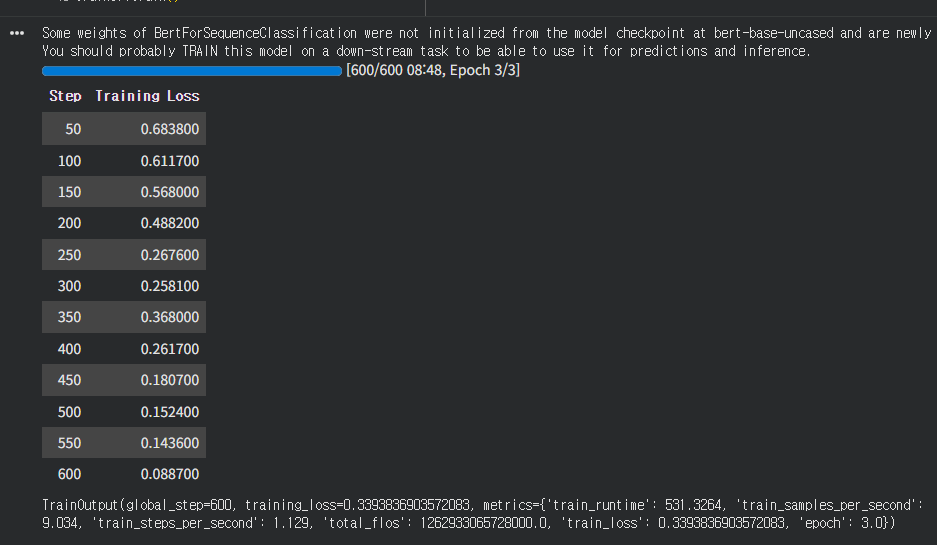

In [ ]:
# # Trainer API
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments
# from sklearn.metrics import classification_report
# import evaluate  #load_metric 대체

# # 모델 로드 클래스 개수 2
# BERT_NAME = 'bert-base-uncased'
# model = BertForSequenceClassification.from_pretrained(BERT_NAME, num_labels=2)
# accuracy_metric = evaluate.load('accuracy')
# precision_metric = evaluate.load('precision')
# recall_metric = evaluate.load('recall')
# f1_metric = evaluate.load('f1')
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=1)
#     return {
#         'accuracy' : accuracy_metric.compute(predictions=predictions, references=labels)['accuracy'],
#         'precision' : precision_metric.compute(predictions=predictions, references=labels)['precision'],
#         'recall' : recall_metric.compute(predictions=predictions, references=labels)['recall'],
#         'f1' : f1_metric.compute(predictions=predictions, references=labels)['f1']
#     }

# # TrainingArguments
# training_args = TrainingArguments(
#     output_dir = './results',
#     num_train_epochs = 3,          # NLP에서는 2~5
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=16,  # 평가는 gradient 안하므로 train보다 크게 설정하는 경향
#     learning_rate=2e-5,
#     weight_decay=0.01,   # L2 정규화 규제 강도
#     logging_dir='./logs',
#     logging_steps=50,
#     eval_strategy = 'epoch',
#     save_strategy = 'epoch',
#     load_best_model_at_end=True,
#     metric_for_best_model='f1',  # 가장좋은 성능 모델은 F1 기준으로 가져오기
#     report_to='none'   
# )

# trainer = Trainer(
#     model = model,
#     args = training_args,
#     train_dataset = train_dataset,
#     eval_dataset = test_dataset,
#     comput_metrics = compute_metrics
# )